# Local adaptive time-stepping for a locally compressed monolayer due to a single proliferation event

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 4.0 # final time
rA = 1.5   # maximum interaction distance
separation = 0.15 # initial separation between daughter cells

dim = 3

seed=67
npr.seed(seed)

dt = 0.05
t_data = np.arange(0, tf, dt)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}


# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim, separation), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim, separation),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim, separation)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [5]:
def make_hexagonal_mesh(l):
# 2D honeycomb mesh
#l=3
    n_x = l+(l//2)+((l-1)//2)
    n_y = l+(l-1)
    xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
    ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

    # make cell_list for the sheet
    sheet = [cl.Cell(i, [x,y], 0.0, proliferating=False) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]

    # delete cells to make it circular - skip for now
    #del sheet[24]
    #del sheet[20]
    #del sheet[19]
    #del sheet[3*l+1+3+1]
    #del sheet[2*l+1+3]
    #del sheet[2*l+1+2]
    #del sheet[l+1]
    #del sheet[0]

    # find middle index, move cell there and add second daughter cells
    m = n_x *(n_y//2)+ n_x//2
    coords = list(sheet[m].position)
    
    # get division direction
    random_angle = 2.0 * np.pi * npr.rand()
    division_direction = np.array([np.cos(random_angle), np.sin(random_angle)])
    
    # update positions
    updated_position_parent = coords - 0.5 * separation * division_direction
    sheet[m].position = updated_position_parent   

    position_daughter = coords + 0.5 * separation * division_direction    
    
    # add daughter cell
    next_cell_index = len(sheet)
    daughter_cell = cl.Cell(next_cell_index, position_daughter, birthtime=0.0, proliferating=False)
    sheet.append(daughter_cell)
        
    return sheet

In [6]:
def make_hcp_mesh(n_x, n_y, n_z, scaling=1.0):
# 3D honeycomb mesh

    coords = [((2 * i_x + ((i_y + i_z) % 2)) * 0.5 * scaling,
             np.sqrt(3) * (i_y + (i_z % 2) / 3.0) * 0.5 * scaling,
             np.sqrt(6) * i_z / 3.0 * scaling)
            for i_x in range(n_x) for i_y in range(n_y) for i_z in range(n_z)
            ]


    # make cell_list for the sheet
    sheet = [cl.Cell(i, [x,y,z], 0.0, proliferating=False) for i, (x, y, z) in enumerate(coords)]


    # find middle index, move cell there and add second daughter cells
    m = (n_x*n_y)*(n_z//2)+n_x*(n_y//2)+n_x//2
    coords = list(sheet[m].position)
    
    # get division direction
    u = npr.rand()
    v = npr.rand()
    random_azimuth_angle = 2 * np.pi * u
    random_zenith_angle = np.arccos(2 * v - 1)
    division_direction = np.array([
                np.cos(random_azimuth_angle) * np.sin(random_zenith_angle),
                np.sin(random_azimuth_angle) * np.sin(random_zenith_angle),
                np.cos(random_zenith_angle)])
    
    # update positions
    updated_position_parent = coords - 0.5 * separation * division_direction
    sheet[m].position = updated_position_parent   

    position_daughter = coords + 0.5 * separation * division_direction    
    
    # add daughter cell
    next_cell_index = len(sheet)
    daughter_cell = cl.Cell(next_cell_index, position_daughter, birthtime=0.0, proliferating=False)
    sheet.append(daughter_cell)
        
    return sheet

In [7]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

In [8]:
# plot function
# eigenvector must contain eigenvector corresponding to a single eigenvalue
def plot_eigenvector_on_population(cell_list, eigenvector, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    eigenvector = eigenvector.reshape((n_cells, -1))
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
        plt.plot([cell_list[i].position[0], cell_list[i].position[0] + eigenvector[i, 0]], [cell_list[i].position[1],cell_list[i].position[1]+eigenvector[i,1]])
    plt.show()

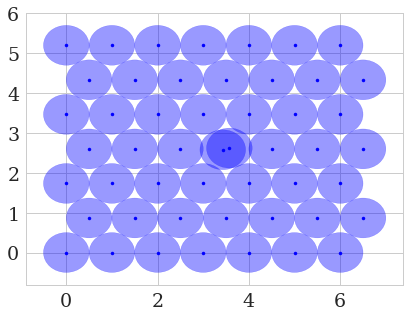

In [9]:
sheet = make_hexagonal_mesh(4)
plot_population(sheet)

In [10]:
sheet = make_hcp_mesh(6,6,6)

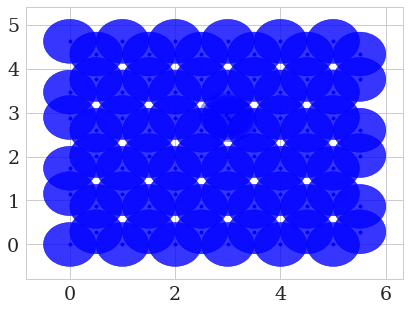

In [11]:
plot_population(sheet)

In [12]:
eps = 0.01
cbmodel = models_ef['cubic']
algorithms = ['glob_adap_acc', 'glob_adap_stab' ,  'local_adap', 'fixed_dt' ]
exec_times = {}
ts_s = {}

n = 10


out = 'glob_adap_acc' 
for i in range(n):
    try:
        os.remove('exec_times'+out+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    ts, history = cbmodel.simulate(sheet, t_data, params_cubic, {"eps": eps, "out": out, "measure_wall_time": True}, seed=seed)
        
    with open('exec_times'+out+'.txt', 'r') as f:
        if i==0:
            exec_times[out] = np.array(np.loadtxt(f))[:, 1]
        else:
            exec_times[out] += np.array(np.loadtxt(f))[:, 1]
exec_times[out] = exec_times[out]/n
ts_s[out] = ts


out = 'glob_adap_stab' 
for i in range(n):
    try:
        os.remove('exec_times'+out+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    ts, history = cbmodel.simulate(sheet, t_data, params_cubic, {"eps": eps, "out": out,"jacobian": cbmodel.jacobian, "force_args": params_cubic, "always_calculate_Jacobian": True, "measure_wall_time": True}, seed=seed)

    with open('exec_times'+out+'.txt', 'r') as f:
        if i==0:
            exec_times[out] = np.array(np.loadtxt(f))[:, 1]
        else:
            exec_times[out] += np.array(np.loadtxt(f))[:, 1]
exec_times[out] = exec_times[out]/n
ts_s[out] = ts

# local adaptivity
out = 'local_adap'
for i in range(n):
    try:
        os.remove('exec_times'+out+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    ts, history = cbmodel.simulate(sheet, t_data, params_cubic, {"eps": eps, "out": out, "jacobian": cbmodel.jacobian, "force_args": params_cubic, "always_calculate_Jacobian": True, "local_adaptivity": True, "measure_wall_time": True}, seed=seed)

    with open('exec_times'+out+'.txt', 'r') as f:
        if i==0:
            exec_times[out] = np.array(np.loadtxt(f))[:, 1]
        else:
            exec_times[out] += np.array(np.loadtxt(f))[:, 1]
exec_times[out] = exec_times[out]/n
ts_s[out] = ts


# fixed time stepping
out = 'fixed_dt' 
#DT = 0.01 #I can make this more specific to this set up
DT = ts_s['glob_adap_acc'][1] - ts_s['glob_adap_acc'][0]
print('DT='+str(DT))
for i in range(n):

    try:
        os.remove('exec_times'+out+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    ts, history = cbmodel.simulate(sheet, t_data, params_cubic, {"dt": DT, "out": out, "measure_wall_time": True}, seed=seed)

    with open('exec_times'+out+'.txt', 'r') as f:
        if i==0:
            exec_times[out] = np.array(np.loadtxt(f))[:, 1]
        else:
            exec_times[out] += np.array(np.loadtxt(f))[:, 1]
exec_times[out] = exec_times[out]/n
ts_s[out] = ts

DT=0.007992107923202532


Text(0, 0.5, 'Wall time [s]')

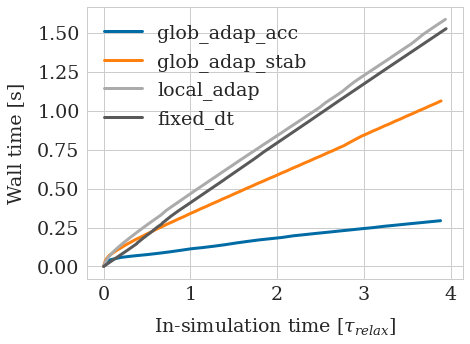

In [13]:
for alg in algorithms:
    plt.plot(ts_s[alg][:-1], exec_times[alg], label=alg)
plt.legend()
plt.xlabel(r'In-simulation time [$ \tau_{relax}$]')
plt.ylabel('Wall time [s]')

In [14]:
eps = 0.01
cbmodel = models_ef['cubic']
algorithms = ['glob_adap_acc', 'glob_adap_stab' ,  'local_adap', 'fixed_dt' ]
exec_times = {}
ts_s = {}

n = 10


out = 'glob_adap_acc' 
for i in range(n):
    try:
        os.remove('exec_times'+out+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    ts, history = cbmodel.simulate(sheet, t_data, params_cubic, {"eps": eps, "out": out, "measure_wall_time": True}, seed=seed)
        
    with open('exec_times'+out+'.txt', 'r') as f:
        if i==0:
            exec_times[out] = np.array(np.loadtxt(f))[:, 1]
        else:
            exec_times[out] += np.array(np.loadtxt(f))[:, 1]
exec_times[out] = exec_times[out]/n
ts_s[out] = ts


out = 'glob_adap_stab' 
for i in range(n):
    try:
        os.remove('exec_times'+out+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    ts, history = cbmodel.simulate(sheet, t_data, params_cubic, {"eps": eps, "out": out,"jacobian": cbmodel.jacobian, "force_args": params_cubic, "measure_wall_time": True}, seed=seed)

    with open('exec_times'+out+'.txt', 'r') as f:
        if i==0:
            exec_times[out] = np.array(np.loadtxt(f))[:, 1]
        else:
            exec_times[out] += np.array(np.loadtxt(f))[:, 1]
exec_times[out] = exec_times[out]/n
ts_s[out] = ts

# local adaptivity
out = 'local_adap'
for i in range(n):
    try:
        os.remove('exec_times'+out+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    ts, history = cbmodel.simulate(sheet, t_data, params_cubic, {"eps": eps, "out": out, "jacobian": cbmodel.jacobian, "force_args": params_cubic, "local_adaptivity": True, "measure_wall_time": True}, seed=seed)

    with open('exec_times'+out+'.txt', 'r') as f:
        if i==0:
            exec_times[out] = np.array(np.loadtxt(f))[:, 1]
        else:
            exec_times[out] += np.array(np.loadtxt(f))[:, 1]
exec_times[out] = exec_times[out]/n
ts_s[out] = ts


# fixed time stepping
out = 'fixed_dt' 
#DT = 0.01 #I can make this more specific to this set up
DT = ts_s['glob_adap_acc'][1] - ts_s['glob_adap_acc'][0]
print('DT='+str(DT))
for i in range(n):

    try:
        os.remove('exec_times'+out+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    ts, history = cbmodel.simulate(sheet, t_data, params_cubic, {"dt": DT, "out": out, "measure_wall_time": True}, seed=seed)

    with open('exec_times'+out+'.txt', 'r') as f:
        if i==0:
            exec_times[out] = np.array(np.loadtxt(f))[:, 1]
        else:
            exec_times[out] += np.array(np.loadtxt(f))[:, 1]
exec_times[out] = exec_times[out]/n
ts_s[out] = ts

DT=0.007992107923202532


Text(0, 0.5, 'Wall time [s]')

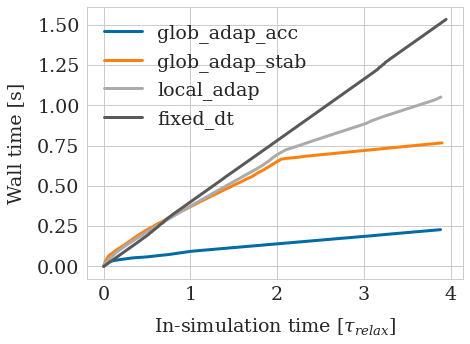

In [15]:
for alg in algorithms:
    plt.plot(ts_s[alg][:-1], exec_times[alg], label=alg)
plt.legend()
plt.xlabel(r'In-simulation time [$ \tau_{relax}$]')
plt.ylabel('Wall time [s]')

# compare error relative to fixed dt solution

In [16]:
import scipy.interpolate as sci

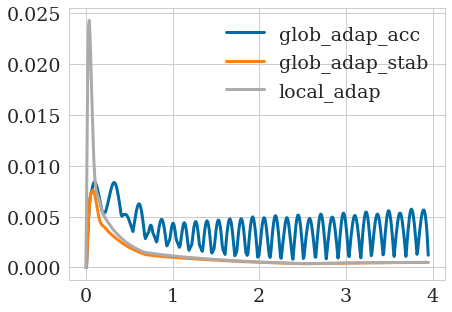

In [17]:


parameters_EF = {'glob_adap_acc': {"eps": eps, "out": 'glob_adap_acc', "measure_wall_time": True}, 
                  'glob_adap_stab': {"eps": eps, "out": 'glob_adap_stab',"jacobian": cbmodel.jacobian, "force_args": params_cubic, "always_calculate_Jacobian": True, "measure_wall_time": True} ,  
                  'local_adap': {"eps": eps, "out": 'local_adap', "jacobian": cbmodel.jacobian, "force_args": params_cubic, "always_calculate_Jacobian": True, "local_adaptivity": True, "measure_wall_time": True} , 
                  'fixed_dt': {"dt": DT, "out": 'fixed_dt', "measure_wall_time": True}}

ref_ts, ref_sol = cbmodel.simulate(sheet, t_data, params_cubic, parameters_EF['fixed_dt'], seed=seed)
ref_traj = np.array(
            [
                [cell.position for cell in cell_list]
                for cell_list in ref_sol
            ]
        ) # (N_ref, n_cells, dim)

algorithms = ['glob_adap_acc', 'glob_adap_stab' ,  'local_adap']


for alg in algorithms:
    ts, history = cbmodel.simulate(sheet, t_data, params_cubic, parameters_EF[alg], seed=seed)
    
    traj = np.array([
        [cell.position for cell in cell_list]
        for cell_list in history
    ]) # (N, n_cells, dim)
    
    
    
    interp = sci.interp1d(
        ts, traj,
        axis=0,
        bounds_error=False, kind='cubic',
        fill_value=tuple(traj[[0, -1], :, :])
    )(ref_ts[:])
    error = np.linalg.norm(interp - ref_traj, ord=np.inf, axis=1)
#        /np.linalg.norm(
#            ref_traj,
#            axis=0, ord=inf)
    
    #).mean(axis=0)
    
    plt.plot(ref_ts, error[:,0], label=alg)    
    
#    print(alg+': '+str(np.mean(error))) #take average over dimensions

plt.legend()

In [18]:
error.shape

(496, 3)

In [19]:


parameters_EF = {'glob_adap_acc': {"eps": eps, "out": 'glob_adap_acc', "measure_wall_time": True}, 
                  'glob_adap_stab': {"eps": eps, "out": 'glob_adap_stab',"jacobian": cbmodel.jacobian, "force_args": params_cubic, "measure_wall_time": True} ,  
                  'local_adap': {"eps": eps, "out": 'local_adap', "jacobian": cbmodel.jacobian, "force_args": params_cubic, "local_adaptivity": True, "measure_wall_time": True} , 
                  'fixed_dt': {"dt": DT, "out": 'fixed_dt', "measure_wall_time": True}}

algorithms = ['glob_adap_acc', 'glob_adap_stab' ,  'local_adap']


for alg in algorithms:
    ts, history = cbmodel.simulate(sheet, t_data, params_cubic, parameters_EF[alg], seed=seed)
    
    traj = np.array([
        [cell.position for cell in cell_list]
        for cell_list in history
    ]) # (N, n_cells, dim)
    
    
    
    interp = sci.interp1d(
        ts, traj,
        axis=0,
        bounds_error=False, kind='cubic',
        fill_value=tuple(traj[[0, -1], :, :])
    )(ref_ts[:])
    error = (
        np.linalg.norm(
            interp - ref_traj,
            axis=0)
        /np.linalg.norm(
            ref_traj,
            axis=0)
    ).mean(axis=0)
    
    print(alg+': '+str(np.mean(error))) #take average over dimensions


glob_adap_acc: 0.00311484404485586
glob_adap_stab: 0.0013417042383532009
local_adap: 0.001366867955960585


In [20]:
eps = 0.01
cbmodel = models_ef['cubic']
algorithms = ['glob_adap_acc', 'glob_adap_stab' ,  'local_adap', 'fixed_dt' ]
F_evaluations = {}


out = 'glob_adap_acc' 

try:
    os.remove('F_evaluations'+out+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
ts, history = cbmodel.simulate(sheet, t_data, params_cubic, {"eps": eps, "out": out, "measure_wall_time": True}, seed=seed)

with open('F_evaluations'+out+'.txt', 'r') as f:
        F_evaluations[out] = np.array(np.loadtxt(f))


out = 'glob_adap_stab' 
try:
    os.remove('F_evaluations'+out+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
ts, history = cbmodel.simulate(sheet, t_data, params_cubic, {"eps": eps, "out": out,"jacobian": cbmodel.jacobian, "force_args": params_cubic, "always_calculate_Jacobian": True, "measure_wall_time": True}, seed=seed)

with open('F_evaluations'+out+'.txt', 'r') as f:
        F_evaluations[out] = np.array(np.loadtxt(f))

# local adaptivity
out = 'local_adap'
try:
    os.remove('F_evaluations'+out+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
ts, history = cbmodel.simulate(sheet, t_data, params_cubic, {"eps": eps, "out": out, "jacobian": cbmodel.jacobian, "force_args": params_cubic, "always_calculate_Jacobian": True, "local_adaptivity": True, "measure_wall_time": True}, seed=seed)

with open('F_evaluations'+out+'.txt', 'r') as f:
        F_evaluations[out] = np.array(np.loadtxt(f))

# fixed time stepping
out = 'fixed_dt' 
#DT = 0.01 #I can make this more specific to this set up
#DT = ts_s['glob_adap_acc'][1] - ts_s['glob_adap_acc'][0]
print('DT='+str(DT))
try:
    os.remove('F_evaluations'+out+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
ts, history = cbmodel.simulate(sheet, t_data, params_cubic, {"dt": DT, "out": out, "measure_wall_time": True}, seed=seed)

with open('F_evaluations'+out+'.txt', 'r') as f:
        F_evaluations[out] = np.array(np.loadtxt(f))


DT=0.007992107923202532


Text(0, 0.5, '# F evaluations')

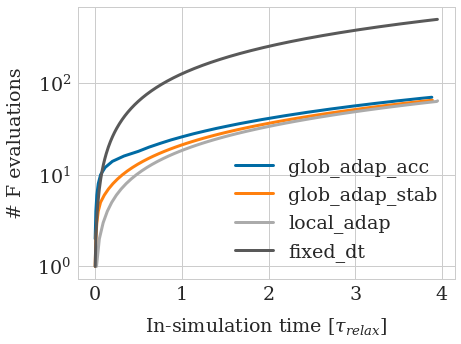

In [24]:
for alg in algorithms:
    plt.semilogy(F_evaluations[alg][:,0], F_evaluations[alg][:,1], label=alg)
plt.legend()
plt.xlabel(r'In-simulation time [$ \tau_{relax}$]')
plt.ylabel('# F evaluations')